In [70]:
import os

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

%matplotlib inline

from scipy.stats import gamma, poisson

import epyestim
import epyestim.covid19 as covid19

<AxesSubplot:xlabel='Date'>

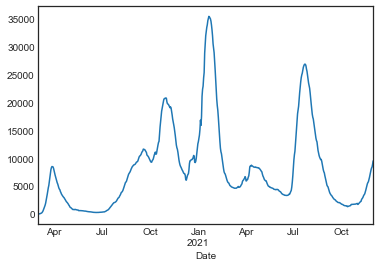

In [73]:
from utils import load_last_final_data
df_ma = load_last_final_data(from_folder='final')
infected = df_ma['Infected']
infected.plot()

In [75]:
df = df_ma.copy()

In [76]:
# constant population
POPULATION = df['Population'].mean()

df2 = df[['Infected', 'Deaths', 'Recovered']]

In [77]:
# Confirmed, Deaths, Recovered and Active cases to SIR form
def CDRA_to_SIR(df, population):
    df2 = df[[]].copy()
    df2["S"] = 0  # Just to produce the desired order
    df2["I"] = df[["Infected"]]
    df2["R"] = df["Deaths"] + df["Recovered"]
    df2["S"] = population - df2["I"] - df2["R"]
    return df2

In [79]:
# transform data
df3 = CDRA_to_SIR(df2, POPULATION)
df3

,S,I,R
Date,,,
2020-03-02,46796514.0,26.0,0.0
2020-03-03,46796502.0,38.0,0.0
2020-03-04,46796489.0,51.0,0.0
2020-03-05,46796465.0,75.0,0.0
2020-03-06,46796428.0,110.0,2.0
...,...,...,...
2021-11-26,46784303.0,7935.0,4302.0
2021-11-27,46783605.0,8263.0,4672.0
2021-11-28,46783051.0,8458.0,5031.0


In [ ]:
# use day count instead of datetime
t = np.linspace(0, len(df3)-1, len(df3))

# S, I, R to array
S = df3['S'].values
I = df3['I'].values
R = df3['R'].values

Estimation of Rt

In [67]:
ch_time_varying_r = covid19.r_covid(df_ma)

ch_time_varying_r.head()

,cases,R_mean,R_var,Q0.025,Q0.5,Q0.975
2020-03-07,149.0,4.412855,0.004128,4.287892,4.412546,4.539175
2020-03-08,197.0,3.213834,0.001815,3.130864,3.213646,3.298195
2020-03-09,279.0,2.514719,0.000950,2.454840,2.514594,2.575310
2020-03-10,415.0,2.156711,0.000594,2.109013,2.156620,2.204757
2020-03-11,593.0,2.007928,0.000433,1.967419,2.007857,2.048845


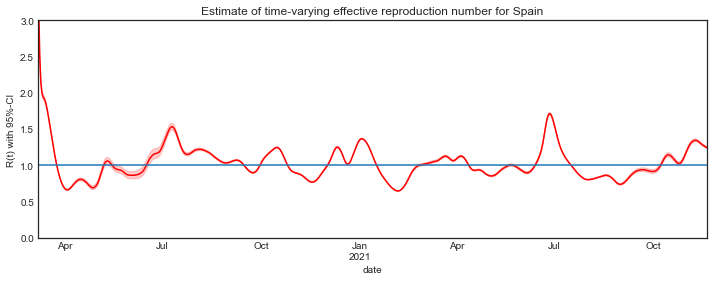

In [69]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))

ch_time_varying_r.loc[:,'Q0.5'].plot(ax=ax, color='red')
ax.fill_between(ch_time_varying_r.index, 
                    ch_time_varying_r['Q0.025'], 
                    ch_time_varying_r['Q0.975'], 
                    color='red', alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('R(t) with 95%-CI')
ax.set_ylim([0,3])
ax.axhline(y=1)
ax.set_title('Estimate of time-varying effective reproduction number for Spain')
plt.show()

Estimation of beta

In [85]:
S_t_fraction = df3['S'][ch_time_varying_r.index] / POPULATION
duration_of_infectiousness = 1/14

R_t = ch_time_varying_r.loc[:,'Q0.5']

beta_t = R_t * 1/(S_t_fraction) * (1/duration_of_infectiousness)

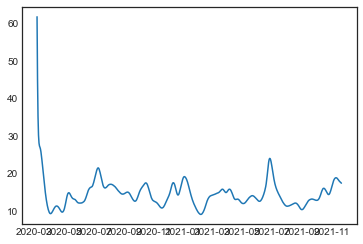

In [86]:
plt.plot(beta_t)

In [145]:
window = df3.loc[ch_time_varying_r.index][40:64]
window

,S,I,R
2020-04-16,46787332.0,3448.0,5760.0
2020-04-17,46787846.0,3308.0,5386.0
2020-04-18,46788205.0,3180.0,5155.0
2020-04-19,46788660.0,3047.0,4833.0
2020-04-20,46789099.0,2960.0,4481.0
2020-04-21,46789518.0,2779.0,4243.0
2020-04-22,46789762.0,2645.0,4133.0
2020-04-23,46790253.0,2475.0,3812.0
2020-04-24,46790617.0,2307.0,3616.0
2020-04-25,46790992.0,2179.0,3369.0


In [150]:
beta = beta_t[40:64-14].mean()
beta

10.7699095701911

In [148]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
N = POPULATION
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = window['I'][-14], window['R'][-14]
# Everyone else, S0, is susceptible to infection initially.
S0 = window['S'][-14]

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = beta, 1./14 
# A grid of time points (in days)

t = np.linspace(0, len(window), len(window))

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))

S, I, R = ret.T

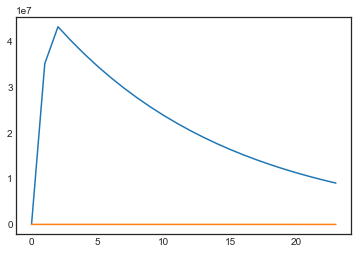

In [149]:
plt.plot(I)
plt.plot(window['I'].values)